In [82]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout, Dense
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, Callback, LearningRateScheduler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceshiptitanic/sample_submission.csv
/kaggle/input/spaceshiptitanic/train.csv
/kaggle/input/spaceshiptitanic/test.csv


In [83]:
dataTrain=pd.read_csv('../input/spaceshiptitanic/train.csv')
dataTest=pd.read_csv('../input/spaceshiptitanic/test.csv')
test_id=dataTest['PassengerId']

dataTrain.drop(labels='Name', inplace=True, axis=1)
#train_data.drop(labels='PassengerId',axis=1, inplace=True)
dataTest.drop(labels='Name',inplace=True, axis=1)
#test_data.drop(labels='PassengerId',axis=1, inplace=True)

dataTrain.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [84]:
def missingData(data):
    numColumns = [column for column in data.select_dtypes(["int", "float"])]
    for i in numColumns:
        data[i].fillna(data[i].mean(), inplace=True)
    catColumns = [column for column in data.select_dtypes(exclude = ["int", "float"])]
    for i in catColumns:
        data[i].fillna(data[i].value_counts().index[0], inplace=True)
    return data

In [85]:
dataTrainNotNull = missingData(dataTrain)
dataTestNotNull = missingData(dataTest)

In [86]:
# processing 
def dataProcessing(dataVar):
    des = pd.get_dummies(dataVar['Destination'],prefix='Des')
    dataVar = pd.concat([dataVar, des], axis=1)
    
    home = pd.get_dummies(dataVar['HomePlanet'], prefix='Home')
    dataVar = pd.concat([dataVar, home], axis=1)
    
    dataVar.drop(labels='Destination', axis=1, inplace=True)
    dataVar.drop(labels='HomePlanet', axis=1, inplace=True)
    
    dataVar['group_num']=dataVar['PassengerId'].apply(lambda x:x.split('_')[0]).astype('int')
    dataVar['in_group_num']=dataVar['PassengerId'].apply(lambda x:x.split('_')[1]).astype('int')
    
    dataVar['deck']=dataVar['Cabin'].apply(lambda x:x.split('/')[0])
    dataVar['num']=dataVar['Cabin'].apply(lambda x:x.split('/')[1])
    dataVar['side']=dataVar['Cabin'].apply(lambda x:x.split('/')[2])
    
    dataVar['num']=dataVar['num'].astype('int')
    
    dataVar['CryoSleep']=dataVar['CryoSleep'].map({False:0, True:1})
    dataVar['VIP']=dataVar['VIP'].map({False:0, True:1})
    dataVar['side']=dataVar['side'].map({'P':0, 'S':1})
    
    dataVar.drop(labels='Cabin', axis=1, inplace=True)
    dataVar.drop(labels='PassengerId', axis=1, inplace=True)
    
    d = pd.get_dummies(dataVar['deck'], prefix='deck')
    dataVar = pd.concat([dataVar, d], axis=1)
    dataVar.drop(labels='deck', axis=1, inplace=True)
    
    return dataVar

In [87]:
dataTrainNew = dataProcessing(dataTrainNotNull)
dataTestNew = dataProcessing(dataTestNotNull)

In [88]:
def dataScaler(dataTrain,dataTest):
    dataTarget = dataTrain['Transported']
    dataFeature = dataTrain.copy()
    dataFeatureTest = dataTest.copy()
    dataFeature.drop(labels='Transported', axis=1, inplace=True)
    fullData = pd.concat([dataFeature, dataFeatureTest])
    
    columnF=[col for col in fullData.select_dtypes(["float",'int'])]
    scalerStd = StandardScaler()
    for j in columnF:
        scalerVar = scalerStd.fit(fullData[j].values.reshape(-1, 1))
        dataFeature[j] = scalerStd.transform(dataFeature[j].values.reshape(-1, 1), scalerVar)
        dataFeatureTest[j] = scalerStd.transform(dataFeatureTest[j].values.reshape(-1, 1), scalerVar)
    return dataFeature,dataTarget,dataFeatureTest


In [89]:
trainFeatureScaled, trainTargetScaled, testFeatureScaled = dataScaler(dataTrainNew,dataTestNew)
trainFeatureScaled.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Des_55 Cancri e,Des_PSO J318.5-22,...,num,side,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T
0,-0.738967,0.718456,-0.146633,-0.347753,-0.288496,-0.299738,-0.275966,-0.262705,0,0,...,-1.183827,-1.014758,0,1,0,0,0,0,0,0
1,-0.738967,-0.335199,-0.146633,-0.177699,-0.282751,-0.256895,0.215181,-0.225027,0,0,...,-1.183827,0.985457,0,0,0,0,0,1,0,0
2,-0.738967,2.053085,6.819762,-0.280667,1.994215,-0.299738,5.731410,-0.220746,0,0,...,-1.183827,0.985457,1,0,0,0,0,0,0,0
3,-0.738967,0.296994,-0.146633,-0.347753,0.530497,0.336051,2.702226,-0.097436,0,0,...,-1.183827,0.985457,1,0,0,0,0,0,0,0
4,-0.738967,-0.897148,-0.146633,0.124967,-0.243812,-0.040967,0.229495,-0.260992,0,0,...,-1.181861,0.985457,0,0,0,0,0,1,0,0


In [90]:
class Loss(Callback):
    def trainBegin(self, logs={}):
        self.loss = []
        self.val_loss = []
    def epochEnd(self, batch, logs={}):
        self.loss.append(logs.get('categorical_accuracy'))
        self.val_loss.append(logs.get('val_categorical_accuracy'))

In [91]:
# nn model and train_try
def modelML(data):
    l = len(data.columns)
    model = Sequential()
    model.add(Dense(64,input_dim=l ,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['categorical_accuracy'])
    return model


nn=modelML(trainFeatureScaled)

trainDataX = trainFeatureScaled.values
trainDataY = trainTargetScaled.values
trainDataY = to_categorical(trainDataY, 2)

nnTrainX, nnTestX, nnTrainY, nnTestY = train_test_split(trainDataX, trainDataY, 
                                                                test_size=0.1, 
                                                                shuffle=True, 
                                                                random_state = 1)
stopEarly = EarlyStopping(monitor='val_categorical_accuracy', patience=50, mode='max')
h = LossHistory()
cbList = [stopEarly,h]
nn.fit(nnTrainX, 
       nnTrainY, 
       epochs=500, 
       batch_size=512,
       validation_data=(nnTestX, nnTestY),
       callbacks = cbList, 
       shuffle=True
       )

Epoch 1/500
16/16 [==============================] - 1s 15ms/step - loss: 0.6579 - categorical_accuracy: 0.6180 - val_loss: 0.5674 - val_categorical_accuracy: 0.7701
Epoch 2/500
16/16 [==============================] - 0s 7ms/step - loss: 0.5659 - categorical_accuracy: 0.7193 - val_loss: 0.4696 - val_categorical_accuracy: 0.7862
Epoch 3/500
16/16 [==============================] - 0s 7ms/step - loss: 0.5111 - categorical_accuracy: 0.7520 - val_loss: 0.4333 - val_categorical_accuracy: 0.8046
Epoch 4/500
16/16 [==============================] - 0s 7ms/step - loss: 0.4849 - categorical_accuracy: 0.7652 - val_loss: 0.4164 - val_categorical_accuracy: 0.8092
Epoch 5/500
16/16 [==============================] - 0s 6ms/step - loss: 0.4640 - categorical_accuracy: 0.7744 - val_loss: 0.4055 - val_categorical_accuracy: 0.8057
Epoch 6/500
16/16 [==============================] - 0s 7ms/step - loss: 0.4550 - categorical_accuracy: 0.7798 - val_loss: 0.4011 - val_categorical_accuracy: 0.8103
Epoch 7/5

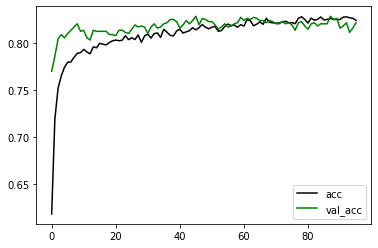

In [92]:
# plot result
accTrain = h.loss
accTest = h.val_loss

plt.plot(accTrain, label='1', color='black')
plt.plot(accTest, label='2', color='green')
plt.legend(['acc', 'val_acc'])
plt.show()

In [93]:
# full nn
nnAll = modelML(trainFeatureScaled)
stopEarlyAll = EarlyStopping(monitor='categorical_accuracy', patience=50, mode='max')
nnAll.fit(trainDataX, 
            trainDataY, 
            epochs=50, 
            batch_size=512,
            #callbacks = [early_stopping_full], 
            shuffle=True
            )
nnAll.save('./nn_model.h5')

Epoch 1/50
17/17 [==============================] - 0s 5ms/step - loss: 0.6738 - categorical_accuracy: 0.5983
Epoch 2/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5742 - categorical_accuracy: 0.7216
Epoch 3/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5119 - categorical_accuracy: 0.7531
Epoch 4/50
17/17 [==============================] - 0s 5ms/step - loss: 0.4853 - categorical_accuracy: 0.7620
Epoch 5/50
17/17 [==============================] - 0s 5ms/step - loss: 0.4627 - categorical_accuracy: 0.7761
Epoch 6/50
17/17 [==============================] - 0s 5ms/step - loss: 0.4562 - categorical_accuracy: 0.7772
Epoch 7/50
17/17 [==============================] - 0s 5ms/step - loss: 0.4499 - categorical_accuracy: 0.7807
Epoch 8/50
17/17 [==============================] - 0s 5ms/step - loss: 0.4418 - categorical_accuracy: 0.7873
Epoch 9/50
17/17 [==============================] - 0s 5ms/step - loss: 0.4349 - categorical_accuracy: 0.7875
Epoch 10/5

In [94]:
# predict with nn
saved=tf.keras.models.load_model('./nn_model.h5')
xInput = testFeatureScaled.values
res = nnAll.predict(xInput, batch_size = 512)
resArray = np.zeros(res.shape[0])
for i in range(res.shape[0]):
    resArray[i]=(res[i][1] > res[i][0])
nnPrediction = pd.Series(resArray).map({0:False, 1:True})
submission=pd.DataFrame({"PassengerId": test_id.values, "Transported": nnPrediction})
submission.to_csv('submission.csv', index = False)